In [1]:
!pip install torchmetrics
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import resample
import torchvision
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torchmetrics import Accuracy, Recall, Precision, F1Score, AUROC, MeanSquaredError
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [2]:
dataset = '/kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection'
train_df = '/kaggle/working/train'
test_df = '/kaggle/working/test'

In [3]:
import shutil

for split_dir in [train_df, test_df]:
    for category in ['yes', 'no']:
        os.makedirs(os.path.join(split_dir, category), exist_ok=True)

print("✅ Train and Test directories created.\n")

# Split and Copy Images
for category in ['yes', 'no']:
    category_path = os.path.join(dataset, category)
    images = os.listdir(category_path)
    print(f"🔍 Found {len(images)} images in category '{category}'.")

    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    print(f"➡️  Moving {len(train_images)} images to Train/{category}")
    print(f"➡️  Moving {len(test_images)} images to Test/{category}\n")

    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(train_df, category, img))

    for img in test_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(test_df, category, img))

print("✅ Dataset splitting and copying completed successfully.\n")

# Final Summary
train_yes_count = len(os.listdir(os.path.join(train_df, 'yes')))
train_no_count = len(os.listdir(os.path.join(train_df, 'no')))
test_yes_count = len(os.listdir(os.path.join(test_df, 'yes')))
test_no_count = len(os.listdir(os.path.join(test_df, 'no')))

print("📊 Final Counts:")
print(f"Train Yes: {train_yes_count}")
print(f"Train No: {train_no_count}")
print(f"Test Yes: {test_yes_count}")
print(f"Test No: {test_no_count}")

✅ Train and Test directories created.

🔍 Found 1500 images in category 'yes'.
➡️  Moving 1200 images to Train/yes
➡️  Moving 300 images to Test/yes

🔍 Found 1500 images in category 'no'.
➡️  Moving 1200 images to Train/no
➡️  Moving 300 images to Test/no

✅ Dataset splitting and copying completed successfully.

📊 Final Counts:
Train Yes: 1200
Train No: 1200
Test Yes: 300
Test No: 300


In [4]:
yes_dir = os.path.join(dataset, 'yes')
no_dir = os.path.join(dataset, 'no')

yes_images = [os.path.join(yes_dir, img) for img in os.listdir(yes_dir)]
no_images = [os.path.join(no_dir, img) for img in os.listdir(no_dir)]

image_paths = yes_images + no_images
labels = [1] * len(yes_images) + [0] * len(no_images)

In [5]:
from PIL import Image

# Print the directories
print(f"Yes Directory: {yes_dir}")
print(f"No Directory: {no_dir}")

# Print sample images count
print(f"Total 'Yes' images (Tumor): {len(yes_images)}")
print(f"Total 'No' images (No Tumor): {len(no_images)}")

# Print total images
print(f"Total Images Collected: {len(image_paths)}")
print(f"Sample Image Path (Yes): {yes_images[0] if yes_images else 'No images found'}")
print(f"Sample Image Path (No): {no_images[0] if no_images else 'No images found'}")

# Print shape and size of sample images
if yes_images:
    img_yes = Image.open(yes_images[0])
    print(f"Shape of 'Yes' image (Tumor): {img_yes.size} (Width x Height)")
if no_images:
    img_no = Image.open(no_images[0])
    print(f"Shape of 'No' image (No Tumor): {img_no.size} (Width x Height)")

# Print labels distribution
print(f"Labels Example: {labels[:10]}")  # Showing first 10 labels as sample
print(f"Total Labels: {len(labels)}")
print(f"Label 1 (Tumor) Count: {labels.count(1)}")
print(f"Label 0 (No Tumor) Count: {labels.count(0)}")


Yes Directory: /kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/yes
No Directory: /kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/no
Total 'Yes' images (Tumor): 1500
Total 'No' images (No Tumor): 1500
Total Images Collected: 3000
Sample Image Path (Yes): /kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/yes/y925.jpg
Sample Image Path (No): /kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/no/no26.jpg
Shape of 'Yes' image (Tumor): (272, 277) (Width x Height)
Shape of 'No' image (No Tumor): (230, 282) (Width x Height)
Labels Example: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Total Labels: 3000
Label 1 (Tumor) Count: 1500
Label 0 (No Tumor) Count: 1500


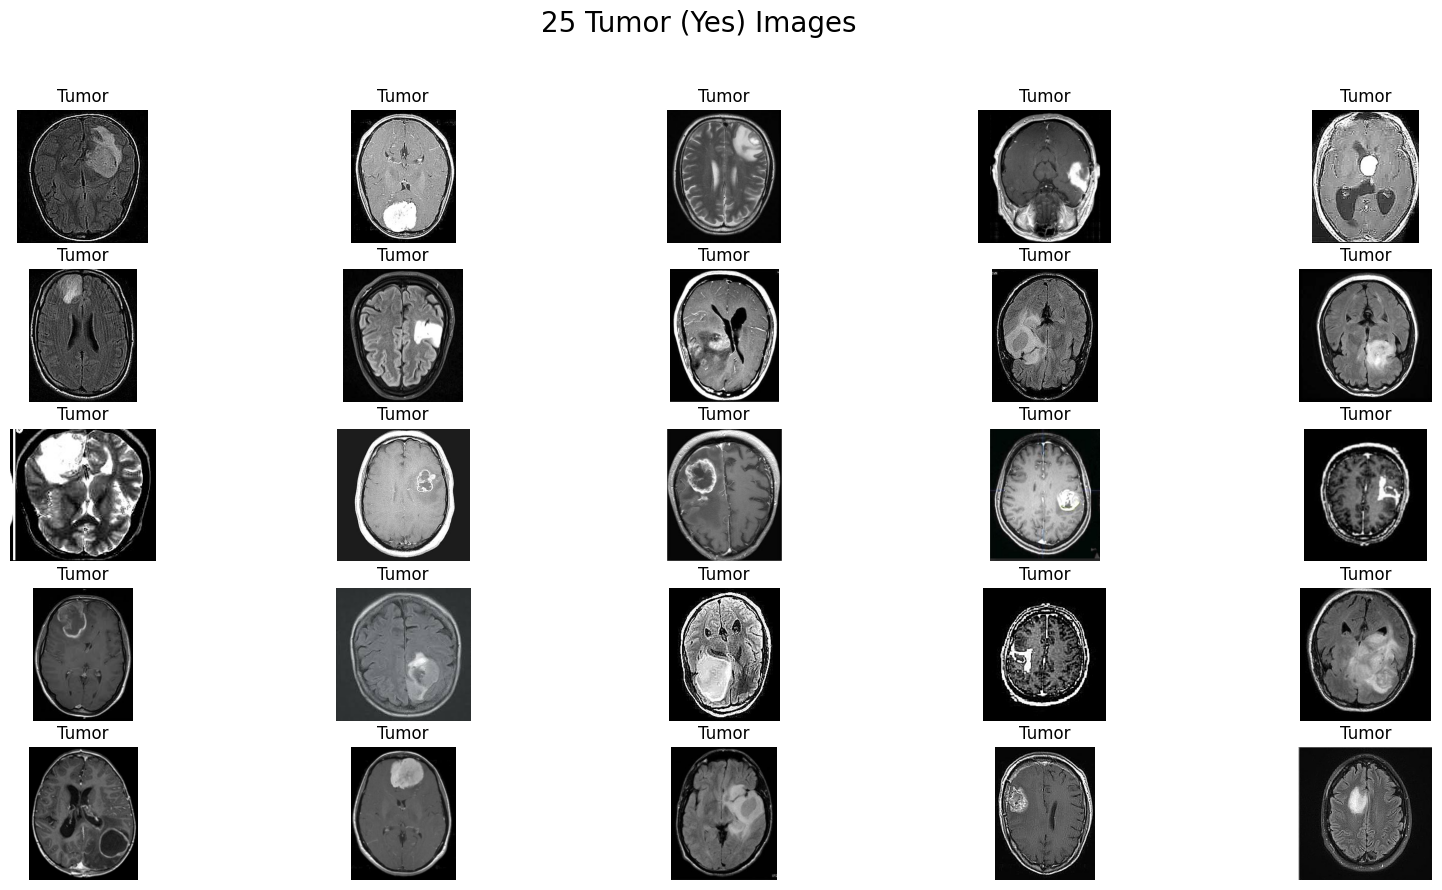

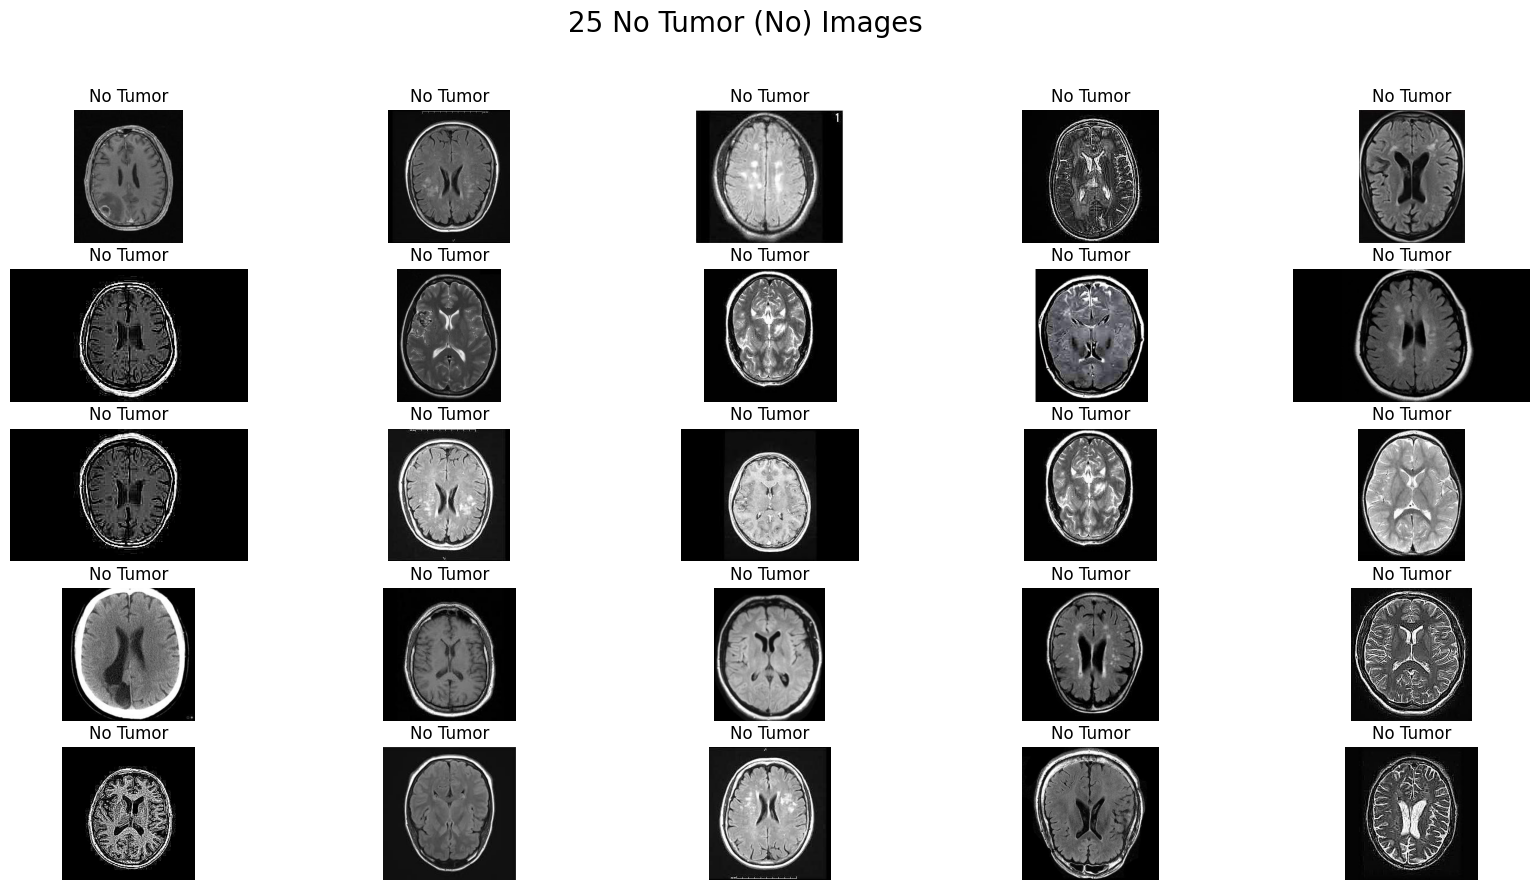

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

def visualize_separate_classes(yes_images, no_images, num_samples=25):
    # YES IMAGES (Tumor)
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        image = Image.open(yes_images[i]).convert('RGB')
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title('Tumor')
        plt.axis('off')
    plt.suptitle("25 Tumor (Yes) Images", fontsize=20)
    plt.show()

    # NO IMAGES (No Tumor)
    plt.figure(figsize=(20, 10))
    for i in range(num_samples):
        image = Image.open(no_images[i]).convert('RGB')
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.title('No Tumor')
        plt.axis('off')
    plt.suptitle("25 No Tumor (No) Images", fontsize=20)
    plt.show()

# Call the function
visualize_separate_classes(yes_images, no_images, num_samples=25)


In [7]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [8]:
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels)


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [10]:
train_dataset = BrainTumorDataset(train_paths, train_labels, transform=transform)
test_dataset = BrainTumorDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
class Classifier(nn.Module):
    def __init__(self, num_classes=2, in_channels=1, pretrained=True):
        super(Classifier, self).__init__()

        # Load pretrained ResNet50
        base_model = models.resnet50(pretrained=pretrained)

        # Modify 1st conv layer for grayscale images
        if in_channels == 1:
            self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
            with torch.no_grad():
                self.conv1.weight = nn.Parameter(base_model.conv1.weight.sum(dim=1, keepdim=True))
        else:
            self.conv1 = base_model.conv1

        # Reuse other layers
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4  # 🔓 Will fine-tune this layer

        self.avgpool = base_model.avgpool  # Global Average Pooling

        # 🔧 Improved classification head
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

        # 🔓 Fine-tune only deeper layers (layer4 + fc)
        for param in self.layer4.parameters():
            param.requires_grad = True
        for param in self.fc.parameters():
            param.requires_grad = True

        # 🔒 Freeze all earlier layers
        for param in self.layer1.parameters():
            param.requires_grad = False
        for param in self.layer2.parameters():
            param.requires_grad = False
        for param in self.layer3.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = self.extract_features(x)         # [B, 2048, 7, 7]
        gap = self.avgpool(features)                # [B, 2048, 1, 1]
        gap = torch.flatten(gap, 1)                 # [B, 2048]
        out = self.fc(gap)                          # [B, num_classes]
        return out

    def extract_features(self, x):  # Used for FCVE
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def extract_gap_features(self, x):  # For filter attribution
        features = self.extract_features(x)
        gap = self.avgpool(features)
        return torch.flatten(gap, 1)

    def forward_from_features(self, features):
        gap = self.avgpool(features)
        out = torch.flatten(gap, 1)
        return self.fc(out)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        print(f"\nEpoch {epoch+1}/{epochs} - Training Started...")

        for batch_idx, (images, labels) in enumerate(train_loader):
            print(f"Processing batch {batch_idx+1}/{len(train_loader)}...", end="\r")
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Train accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train

        # Validation step
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}")

# Train the model
train_model(classifier, train_loader, test_loader, criterion, optimizer, epochs=5)


Epoch 1/5 - Training Started...
Epoch 1/5, Train Loss: 0.1388, Train Accuracy: 0.9450, Val Loss: 0.0352, Val Accuracy: 0.9883

Epoch 2/5 - Training Started...
Epoch 2/5, Train Loss: 0.0574, Train Accuracy: 0.9808, Val Loss: 0.0342, Val Accuracy: 0.9867

Epoch 3/5 - Training Started...
Epoch 3/5, Train Loss: 0.0315, Train Accuracy: 0.9879, Val Loss: 0.0252, Val Accuracy: 0.9950

Epoch 4/5 - Training Started...
Epoch 4/5, Train Loss: 0.0075, Train Accuracy: 0.9975, Val Loss: 0.0245, Val Accuracy: 0.9933

Epoch 5/5 - Training Started...
Epoch 5/5, Train Loss: 0.0076, Train Accuracy: 0.9967, Val Loss: 0.0747, Val Accuracy: 0.9800


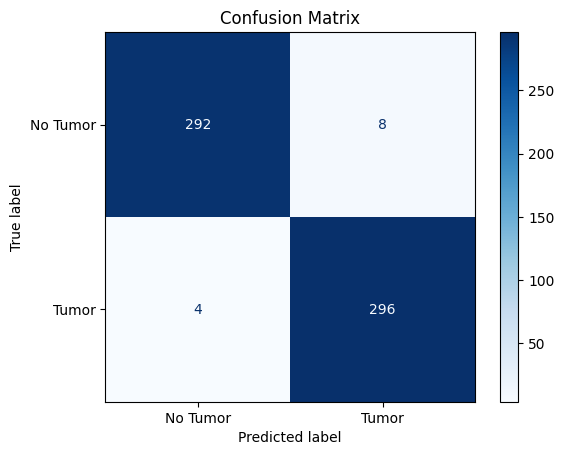

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Tumor", "Tumor"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(classifier, test_loader)


In [15]:
from sklearn.metrics import classification_report

def classification_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=['No Tumor', 'Tumor']))

# Run it on test_loader
classification_metrics(classifier, test_loader)

              precision    recall  f1-score   support

    No Tumor       0.99      0.97      0.98       300
       Tumor       0.97      0.99      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



In [16]:
class Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)

        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)


        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4  # Output: [B, 2048, 7, 7]

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x  # Return feature map [B, 2048, 7, 7]

In [17]:

class Decoder(nn.Module):
    def __init__(self, out_channels=1):  # For grayscale image
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2),  # 7x7 → 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),   # 14x14 → 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),    # 28x28 → 56x56
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),    # 56x56 → 112x112
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),     # 112x112 → 224x224
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),    # Final smoothing
            nn.Sigmoid()  # Output image pixels in [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)

In [18]:
class AutoEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(pretrained=pretrained)
        self.decoder = Decoder(out_channels=1)  # 1-channel for grayscale X-rays

    def forward(self, x):
        features = self.encoder(x)         # [B, 2048, 7, 7]
        reconstructed = self.decoder(features)  # [B, 1, 224, 224]
        return reconstructed

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Auto-Encoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder().to(device)
recon_loss_fn = nn.MSELoss()
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
num_epochs_ae = 10

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [21]:
train_dataset = BrainTumorDataset(train_paths, train_labels, transform=transform)
test_dataset = BrainTumorDataset(test_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
def train_autoencoder_epoch(autoencoder, train_loader, criterion, optimizer, device):
    autoencoder.train()
    classifier.eval()
    for param in classifier.parameters():
        param.requires_grad = False
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

# ==== 1. Autoencoder Training ====
print("==== Training Autoencoder ====")
for epoch in range(num_epochs_ae):
    train_loss = train_autoencoder_epoch(autoencoder, train_loader, recon_loss_fn, ae_optimizer, device)
    print(f"[Autoencoder] Epoch {epoch+1}/{num_epochs_ae} - Train Loss: {train_loss:.4f}")

==== Training Autoencoder ====
[Autoencoder] Epoch 1/10 - Train Loss: 1.1892
[Autoencoder] Epoch 2/10 - Train Loss: 0.6425
[Autoencoder] Epoch 3/10 - Train Loss: 0.4814
[Autoencoder] Epoch 4/10 - Train Loss: 0.4147
[Autoencoder] Epoch 5/10 - Train Loss: 0.3515
[Autoencoder] Epoch 6/10 - Train Loss: 0.3070
[Autoencoder] Epoch 7/10 - Train Loss: 0.3020
[Autoencoder] Epoch 8/10 - Train Loss: 0.2813
[Autoencoder] Epoch 9/10 - Train Loss: 0.2582
[Autoencoder] Epoch 10/10 - Train Loss: 0.2421


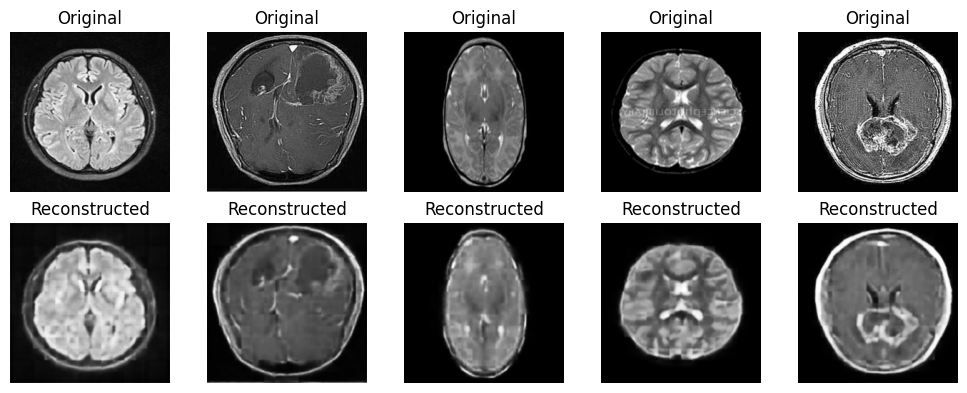

In [23]:
def visualize_reconstructions(autoencoder, data_loader, device, num_images=5):
    autoencoder.eval()
    with torch.no_grad():
        # Ek batch le lo
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            recons = autoencoder(imgs)
            imgs = imgs.cpu().numpy()
            recons = recons.cpu().numpy()
            break  # Only one batch
    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i+1)
        plt.imshow(imgs[i][0], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        # Reconstruction
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(recons[i][0], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_reconstructions(autoencoder, train_loader, device, num_images=5)

In [24]:
class MCHead(nn.Module):
    def __init__(self, base_model):
        super(MCHead, self).__init__()
        self.base = base_model
        self.mc_mask = nn.Conv2d(2048, 2048, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.bn = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.base(x)
        mask = torch.sigmoid(self.mc_mask(x))
        masked_features = x * mask
        x = self.pool(masked_features).view(x.size(0), -1)
        x = self.bn(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.sigmoid(logits), mask

# 4. Custom MC Loss
class MCLoss(nn.Module):
    def __init__(self, lambda_l1=0.01, lambda_logits=0.1):
        super(MCLoss, self).__init__()
        self.lambda_l1 = lambda_l1
        self.lambda_logits = lambda_logits
        self.bce = nn.BCELoss()

    def forward(self, y_pred, y_true, mask):
        y_true = y_true.float().view(-1, 1)
        pred_loss = self.bce(y_pred, y_true)
        sparsity_loss = torch.mean(torch.abs(mask))
        logits = torch.log(y_pred / (1 - y_pred + 1e-7))
        logits_loss = nn.BCEWithLogitsLoss()(logits, y_true)
        return pred_loss + self.lambda_l1 * sparsity_loss + self.lambda_logits * logits_loss

In [25]:
# Load pretrained ResNet50 as base model
base_model = classifier
base_model = nn.Sequential(*list(base_model.children())[:-2])  # Remove FC layers
base_model.to(device).eval()

# Initialize MC Model
model = MCHead(base_model).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = MCLoss()

In [26]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs, mask = model(images)
        loss = criterion(outputs, labels, mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")

# 5. Save Model
torch.save(model.state_dict(), "mc_model.pth")
print("Saved mc_model.pth")

Epoch [1/10], Loss: 0.05034174466505647
Epoch [2/10], Loss: 0.013539266188939412
Epoch [3/10], Loss: 0.011560565552984675
Epoch [4/10], Loss: 0.009429419292137026
Epoch [5/10], Loss: 0.006991957239806652
Epoch [6/10], Loss: 0.006825650886942943
Epoch [7/10], Loss: 0.005712268737455209
Epoch [8/10], Loss: 0.011496133068576456
Epoch [9/10], Loss: 0.004427667579924067
Epoch [10/10], Loss: 0.00880136715248227
Saved mc_model.pth


In [27]:
mc_model = MCHead(base_model).to(device)
mc_model.load_state_dict(torch.load("mc_model.pth"))
mc_model.eval()

# Evaluation on a single batch (or loop over test_loader if you want all)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        # Original Prediction
        outputs, mask = mc_model(images)
        original_pred = outputs

        # Disable MC Filters (set mask to zeros)
        zero_mask = torch.zeros_like(mask)
        masked_features = mc_model.base(images) * zero_mask
        pooled = F.adaptive_avg_pool2d(masked_features, 1).view(images.size(0), -1)
        pooled = mc_model.bn(pooled)
        pooled = mc_model.relu(mc_model.fc1(pooled))
        pooled = mc_model.dropout(pooled)
        logits = mc_model.fc2(pooled)
        modified_pred = torch.sigmoid(logits)

        # Show Predictions Before and After Disabling MC Filters
        print(f"Original Prediction: {original_pred.squeeze().cpu().numpy()}")
        print(f"After Disabling MC Filters: {modified_pred.squeeze().cpu().numpy()}")

        break  # Remove break to evaluate on entire test_loader


/tmp/ipykernel_31/3830834807.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mc_model.load_state_dict(torch.load("mc_model.pth"))


Original Prediction: [9.9999976e-01 9.9999094e-01 2.0372620e-06 9.9999785e-01 4.6687750e-05
 9.9951172e-01 9.9999988e-01 9.9984598e-01 8.2340097e-04 9.9999607e-01
 1.1301972e-05 9.9999547e-01 3.9128727e-06 9.9968338e-01 9.9986303e-01
 9.9999297e-01 1.0422414e-05 9.9996996e-01 9.9999666e-01 9.9999952e-01
 1.0172083e-06 9.9968231e-01 9.9999928e-01 9.9999952e-01 3.7215923e-06
 1.0781632e-06 3.0643692e-05 9.9999034e-01 9.9999368e-01 8.7357519e-05
 9.9999726e-01 6.7909502e-07]
After Disabling MC Filters: [0.07867896 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896
 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896
 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896
 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896
 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896 0.07867896
 0.07867896 0.07867896]


In [28]:
class MIHead(nn.Module):
    def __init__(self, base_model):
        super(MIHead, self).__init__()
        self.base = base_model
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dense_mi = nn.Linear(2048, 2048)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.base(x)
        x = self.pool(x).view(x.size(0), -1)
        mi_weights = self.relu(self.dense_mi(x))
        scaled_features = x * mi_weights
        x = self.bn(scaled_features)
        x = self.fc1(x)
        x = self.dropout(x)
        logits = self.fc2(x)
        return torch.sigmoid(logits), mi_weights

# 2. Custom MI Loss
class MILoss(nn.Module):
    def __init__(self, lambda_l1=0.5):
        super(MILoss, self).__init__()
        self.lambda_l1 = lambda_l1
        self.bce = nn.BCELoss()

    def forward(self, y_pred, y_true, mi_weights):
        y_true = y_true.float().view(-1, 1)
        pred_loss = self.bce(y_pred, y_true)
        sparsity_loss = torch.mean(torch.abs(mi_weights))
        return pred_loss + self.lambda_l1 * sparsity_loss


In [29]:
model = MIHead(base_model).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = MILoss()

In [30]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs, mi_weights = model(images)
        loss = criterion(outputs, labels, mi_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}")

# 5. Save Model
torch.save(model.state_dict(), "mi_model.pth")
print("Saved mi_model.pth")


Epoch [1/10], Loss: 0.05390222489833832
Epoch [2/10], Loss: 0.022902214241524537
Epoch [3/10], Loss: 0.02192120858778556
Epoch [4/10], Loss: 0.021328314306835332
Epoch [5/10], Loss: 0.018456348634014526
Epoch [6/10], Loss: 0.013655982414881388
Epoch [7/10], Loss: 0.009451618008315564
Epoch [8/10], Loss: 0.0163583713149031
Epoch [9/10], Loss: 0.02187956010301908
Epoch [10/10], Loss: 0.021890959789355596
Saved mi_model.pth


In [31]:
# Load trained MI model
mi_model = MIHead(base_model).to(device)
mi_model.load_state_dict(torch.load("mi_model.pth"))
mi_model.eval()

# Evaluation on a single batch (or loop over test_loader if you want all)
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        # Original Prediction
        outputs, mi_weights = mi_model(images)
        original_pred = outputs

        # Enable MI Filters (apply mi_weights more strongly)
        enhanced_features = mi_model.base(images)
        pooled = F.adaptive_avg_pool2d(enhanced_features, 1).view(images.size(0), -1)
        boosted_mi_weights = mi_model.relu(mi_model.dense_mi(pooled)) * 2  # Boost influence
        scaled_features = pooled * boosted_mi_weights
        scaled_features = mi_model.bn(scaled_features)
        scaled_features = mi_model.fc1(scaled_features)
        scaled_features = mi_model.dropout(scaled_features)
        logits = mi_model.fc2(scaled_features)
        modified_pred = torch.sigmoid(logits)

        # Show Predictions Before and After Enabling MI Filters
        print(f"Original Prediction: {original_pred.squeeze().cpu().numpy()}")
        print(f"After Enabling MI Filters: {modified_pred.squeeze().cpu().numpy()}")

        break  # Remove break to evaluate on entire test_loader


/tmp/ipykernel_31/2379155586.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mi_model.load_state_dict(torch.load("mi_model.pth"))


Original Prediction: [9.9999475e-01 9.9889416e-01 1.0143858e-03 9.9995720e-01 1.0954677e-03
 9.9384165e-01 9.9999297e-01 9.9452400e-01 1.8088589e-03 9.9984896e-01
 7.9296896e-04 9.9885690e-01 8.5034437e-04 9.9254417e-01 9.9797338e-01
 9.9949503e-01 1.9708213e-03 9.9930370e-01 9.9989605e-01 9.9998450e-01
 8.2881324e-04 9.8281521e-01 9.9993300e-01 9.9997437e-01 1.2740253e-03
 1.2489681e-03 1.8413503e-03 9.9966574e-01 9.9985242e-01 2.7494088e-03
 9.9991047e-01 1.4953363e-03]
After Enabling MI Filters: [1.0000000e+00 9.9999797e-01 6.1145636e-07 1.0000000e+00 7.1322711e-07
 9.9993527e-01 1.0000000e+00 9.9994886e-01 1.9474185e-06 1.0000000e+00
 3.7349008e-07 9.9999774e-01 4.2954224e-07 9.9990487e-01 9.9999309e-01
 9.9999952e-01 2.3125101e-06 9.9999917e-01 1.0000000e+00 1.0000000e+00
 4.0804758e-07 9.9948466e-01 1.0000000e+00 1.0000000e+00 9.6502731e-07
 9.2739407e-07 2.0181371e-06 9.9999976e-01 1.0000000e+00 4.5075922e-06
 1.0000000e+00 1.3300084e-06]


In [32]:
mc_model = MCHead(base_model).to(device)
mc_model.load_state_dict(torch.load("mc_model.pth"))
mc_model.eval()

mi_model = MIHead(base_model).to(device)
mi_model.load_state_dict(torch.load("mi_model.pth"))
mi_model.eval()

/tmp/ipykernel_31/3310463659.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mc_model.load_state_dict(torch.load("mc_model.pth"))
/tmp/ipykernel_31/3310463659.py:6: Futu

MIHead(
  (base): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256,

In [33]:
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img = Image.open(image_path).convert("L")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img, img_tensor

image_path = '/kaggle/input/brain-tumor-detection-mri/Brain_Tumor_Detection/yes/y1001.jpg'  # Replace with your image path
original_img, input_img = preprocess_image(image_path)

In [34]:
import cv2

In [35]:
def get_topk_mc_mi_indices(image_tensor, mc_model, mi_model, top_k=5):
    """
    Returns the top-k MC and MI filter indices for a given image.

    Args:
        image_tensor (torch.Tensor): [1, 1, H, W] Grayscale image tensor.
        mc_model (torch.nn.Module): Trained MCHead model.
        mi_model (torch.nn.Module): Trained MIHead model.
        top_k (int): Number of top filters to return.

    Returns:
        topk_mc_indices (np.ndarray): Indices of top-k MC filters (from 0 to 2047).
        topk_mi_indices (np.ndarray): Indices of top-k MI filters (from 0 to 2047).
    """
    with torch.no_grad():
        # MC Forward Pass
        mc_outputs, mc_mask = mc_model(image_tensor)  # mc_mask: [1, 2048, 7, 7]
        mc_mask_cpu = mc_mask.squeeze().cpu().numpy()  # [2048, 7, 7]

        # Compute mean activation per channel
        mc_channel_mean = mc_mask_cpu.mean(axis=(1, 2))  # [2048]
        topk_mc_indices = mc_channel_mean.argsort()[-top_k:][::-1]  # Top-k MC filter indices

        # MI Forward Pass
        mi_outputs, mi_weights = mi_model(image_tensor)  # mi_weights: [1, 2048]
        mi_weights_cpu = mi_weights.squeeze().cpu().numpy()  # [2048]

        # Top-k MI filter indices
        topk_mi_indices = np.abs(mi_weights_cpu).argsort()[-top_k:][::-1]  # Top-k MI filter indices

    return topk_mc_indices, topk_mi_indices

# Example image already preprocessed as [1, 1, 224, 224]
topk_mc_indices, topk_mi_indices = get_topk_mc_mi_indices(input_img, mc_model, mi_model, top_k=5)

print("Top-K MC Filter Indices:", topk_mc_indices)
print("Top-K MI Filter Indices:", topk_mi_indices)

Top-K MC Filter Indices: [1158   55 1515  628 1844]
Top-K MI Filter Indices: [1929 1688  158 1282  279]


In [36]:
# Pass the image through the Encoder to get latent feature map
with torch.no_grad():
    latent_features = autoencoder.encoder(input_img)  # [1, 2048, 7, 7]

In [37]:
# Get mask from MCHead
with torch.no_grad():
    _, mc_mask = mc_model(input_img)  # [1, 2048, 7, 7]

# Disable important filters
perturbed_features_mc = latent_features * (1 - mc_mask)

# Get MI weights from MIHead
with torch.no_grad():
    _, mi_weights = mi_model(input_img)  # [1, 2048]

# Reshape mi_weights to match feature map shape [1, 2048, 1, 1]
mi_weights_reshaped = mi_weights.view(1, -1, 1, 1)

# Amplify important filters
perturbed_features_mi = latent_features * (1 + mi_weights_reshaped)


In [38]:
with torch.no_grad():
    counterfactual_mc_image = autoencoder.decoder(perturbed_features_mc)
    counterfactual_mi_image = autoencoder.decoder(perturbed_features_mi)

In [39]:
with torch.no_grad():
    original_pred = classifier(input_img)
    mc_pred = classifier(counterfactual_mc_image)
    mi_pred = classifier(counterfactual_mi_image)

# Convert to class labels and confidence scores
original_class = torch.argmax(original_pred, dim=1).item()
original_conf = torch.softmax(original_pred, dim=1).max().item()

mc_class = torch.argmax(mc_pred, dim=1).item()
mc_conf = torch.softmax(mc_pred, dim=1).max().item()

mi_class = torch.argmax(mi_pred, dim=1).item()
mi_conf = torch.softmax(mi_pred, dim=1).max().item()

print(f"Original Class: {original_class}, Confidence: {original_conf:.4f}")
print(f"MC Counterfactual Class: {mc_class}, Confidence: {mc_conf:.4f}")
print(f"MI Counterfactual Class: {mi_class}, Confidence: {mi_conf:.4f}")

Original Class: 1, Confidence: 0.9999
MC Counterfactual Class: 1, Confidence: 0.8813
MI Counterfactual Class: 0, Confidence: 0.8081


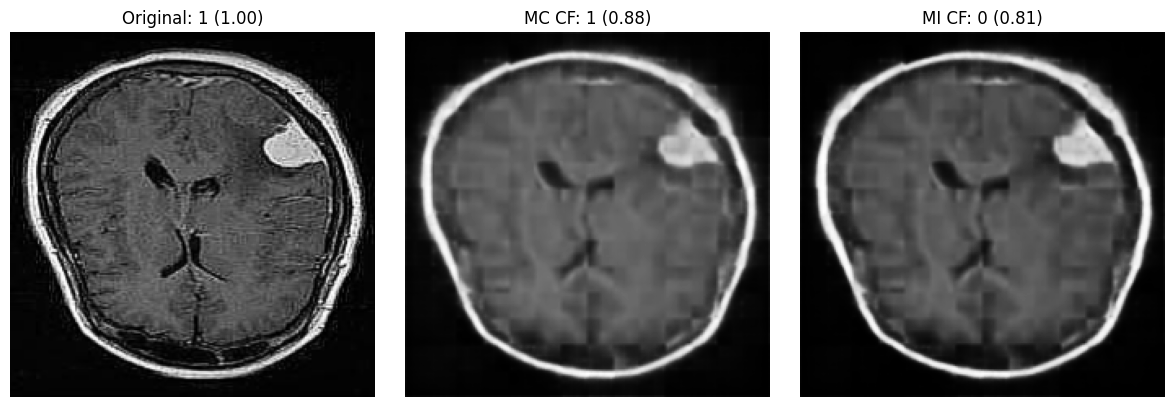

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(input_img.squeeze().cpu(), cmap='gray')
plt.title(f"Original: {original_class} ({original_conf:.2f})")
plt.axis('off')

# MC Counterfactual
plt.subplot(1, 3, 2)
plt.imshow(counterfactual_mc_image.squeeze().cpu(), cmap='gray')
plt.title(f"MC CF: {mc_class} ({mc_conf:.2f})")
plt.axis('off')

# MI Counterfactual
plt.subplot(1, 3, 3)
plt.imshow(counterfactual_mi_image.squeeze().cpu(), cmap='gray')
plt.title(f"MI CF: {mi_class} ({mi_conf:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
from skimage.metrics import structural_similarity as ssim

# Convert to NumPy and squeeze
original = input_img.squeeze().cpu().numpy()
counterfactual = counterfactual_mc_image.squeeze().cpu().numpy()

original = (original / 255.0).astype(np.float32)
counterfactual = (counterfactual / 255.0).astype(np.float32)

score, _ = ssim(original, counterfactual, data_range=1.0, full=True)
# Compute SSIM with data_range specified
#score, _ = ssim(original, counterfactual, full=True, data_range=255)

print("SSIM Score:", score)


SSIM Score: 0.9996083716084064


In [42]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
import lpips
import torch

# Initialize LPIPS with pretrained AlexNet (you can also use 'vgg')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize LPIPS
loss_fn = lpips.LPIPS(net='alex').to(device)

# Convert numpy image to LPIPS format
def to_lpips_tensor(np_img):
    tensor = torch.tensor(np_img).unsqueeze(0)       # [1, H, W]
    tensor = tensor.repeat(3, 1, 1).unsqueeze(0)      # [1, 3, H, W]
    tensor = (tensor * 2) - 1                         # Normalize to [-1, 1]
    return tensor.to(device)

# Prepare original and counterfactual
original = input_img.squeeze().cpu().numpy()
counterfactual = counterfactual_mc_image.squeeze().cpu().numpy()

# Normalize [0, 255] → [0, 1]
original = (original / 255.0).astype(np.float32)
counterfactual = (counterfactual / 255.0).astype(np.float32)

# Convert to LPIPS tensors
img1 = to_lpips_tensor(original)
img2 = to_lpips_tensor(counterfactual)

# Compute LPIPS
lpips_score = loss_fn(img1, img2)
print("LPIPS Score:", lpips_score.item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 238MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS Score: 0.00019541021902114153


/usr/local/lib/python3.11/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [44]:
import numpy as np

# Compute Proximity (L1 distance normalized by image size)
def compute_proximity(original, counterfactual):
    """
    original, counterfactual: numpy arrays with shape [H, W] in range [0, 1]
    """
    l1_distance = np.abs(original - counterfactual).sum()
    H, W = original.shape
    proximity = l1_distance / (1 * H * W)  # C=1 for grayscale
    return proximity

# Call the function
proximity_score = compute_proximity(original, counterfactual)
print(f"Proximity Score (L1): {proximity_score:.4f}")


Proximity Score (L1): 0.0002


In [45]:
from torchvision.utils import save_image

os.makedirs("/mnt/data/MC_Counterfactuals", exist_ok=True)
os.makedirs("/mnt/data/MI_Counterfactuals", exist_ok=True)

classifier.eval()
autoencoder.eval()
mc_model.eval()
mi_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for batch_idx, (imgs, labels) in enumerate(test_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        # 1. Encode the image
        feats = autoencoder.encoder(imgs)  # [B, 2048, 7, 7]

        # 2. Get MC mask and disable important filters
        _, mc_mask = mc_model(imgs)  # [B, 2048, 7, 7]
        mc_perturbed = feats * (1 - mc_mask)
        mc_cf_images = autoencoder.decoder(mc_perturbed)

        # 3. Get MI weights and amplify important filters
        _, mi_weights = mi_model(imgs)  # [B, 2048]
        mi_weights_reshaped = mi_weights.view(-1, 2048, 1, 1)
        mi_perturbed = feats * (1 + mi_weights_reshaped)
        mi_cf_images = autoencoder.decoder(mi_perturbed)

        # 4. Get predictions
        orig_preds = classifier(imgs)
        mc_preds = classifier(mc_cf_images)
        mi_preds = classifier(mi_cf_images)

        orig_classes = torch.argmax(orig_preds, dim=1)
        mc_classes = torch.argmax(mc_preds, dim=1)
        mi_classes = torch.argmax(mi_preds, dim=1)

        # 5. Loop through batch and save each image
        for i in range(imgs.size(0)):
            idx = batch_idx * imgs.size(0) + i  # Global index
            label = labels[i].item()
            orig_class = orig_classes[i].item()
            mc_class = mc_classes[i].item()
            mi_class = mi_classes[i].item()

            # Save MC counterfactual image
            mc_path = f"/mnt/data/MC_Counterfactuals/img_{idx}_T{label}_O{orig_class}_MC{mc_class}.png"
            save_image(mc_cf_images[i], mc_path)

            # Save MI counterfactual image
            mi_path = f"/mnt/data/MI_Counterfactuals/img_{idx}_T{label}_O{orig_class}_MI{mi_class}.png"
            save_image(mi_cf_images[i], mi_path)

In [46]:
import os
import re
import glob
import torch
import numpy as np
import pandas as pd
from PIL import Image
from lpips import LPIPS
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lpips_loss = LPIPS(net='alex').to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def load_image(path):
    img = Image.open(path).convert('L')
    return transform(img).squeeze().numpy()

def to_lpips_tensor(img):
    tensor = torch.tensor(img).unsqueeze(0)
    tensor = tensor.repeat(3, 1, 1).unsqueeze(0)
    return (tensor * 2 - 1).to(device)

def compute_metrics(original, counterfactual):
    original = original.astype(np.float32) / 255.0 if original.max() > 1 else original
    counterfactual = counterfactual.astype(np.float32) / 255.0 if counterfactual.max() > 1 else counterfactual

    ssim_score = ssim(original, counterfactual, data_range=1.0)
    img1 = to_lpips_tensor(original)
    img2 = to_lpips_tensor(counterfactual)
    lpips_score = lpips_loss(img1, img2).item()
    proximity = torch.norm(torch.tensor(original) - torch.tensor(counterfactual)).item()
    return ssim_score, lpips_score, proximity

mc_folder = "/mnt/data/MC_Counterfactuals"
mi_folder = "/mnt/data/MI_Counterfactuals"

results = []
recall_tracker_mc = defaultdict(lambda: {'correct': 0, 'cf_correct': 0})
recall_tracker_mi = defaultdict(lambda: {'correct': 0, 'cf_correct': 0})

mc_files = sorted([f for f in os.listdir(mc_folder) if f.endswith(".png")])

for fname in mc_files:
    match = re.match(r"img_(\d+)_T(\d+)_O(\d+)_MC(\d+)\.png", fname)
    if not match:
        continue

    idx, true, orig, mc = map(int, match.groups())
    mc_path = os.path.join(mc_folder, fname)

    # Match corresponding MI file
    mi_pattern = fname.replace(f"_MC{mc}", "_MI*")
    mi_matches = glob.glob(os.path.join(mi_folder, mi_pattern))
    if not mi_matches:
        continue
    mi_path = mi_matches[0]

    # Extract mi_class from filename
    mi_match = re.match(r".*MI(\d+)\.png", mi_path)
    if mi_match:
        mi = int(mi_match.group(1))
    else:
        continue

    # Load images
    orig_img = load_image(mc_path)  # for comparison, we assume mc_path is based on original input
    mc_img = load_image(mc_path)
    mi_img = load_image(mi_path)

    # Compute metrics
    ssim_mc, lpips_mc, prox_mc = compute_metrics(orig_img, mc_img)
    ssim_mi, lpips_mi, prox_mi = compute_metrics(orig_img, mi_img)

    # Recall Tracking
    if true == orig:
        recall_tracker_mc[true]['correct'] += 1
        if mc == true:
            recall_tracker_mc[true]['cf_correct'] += 1

        recall_tracker_mi[true]['correct'] += 1
        if mi == true:
            recall_tracker_mi[true]['cf_correct'] += 1

    results.append({
        "index": idx,
        "true_label": true,
        "original_class": orig,
        "mc_class": mc,
        "mi_class": mi,
        "ssim_mc": ssim_mc,
        "lpips_mc": lpips_mc,
        "proximity_mc": prox_mc,
        "ssim_mi": ssim_mi,
        "lpips_mi": lpips_mi,
        "proximity_mi": prox_mi,
    })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("/mnt/data/final_cf_metrics.csv", index=False)
print("\n📊 Average Metrics (across all samples):")
print(f"SSIM MC: {df['ssim_mc'].mean():.4f}, MI: {df['ssim_mi'].mean():.4f}")
print(f"LPIPS MC: {df['lpips_mc'].mean():.4f}, MI: {df['lpips_mi'].mean():.4f}")
print(f"L2 Proximity MC: {df['proximity_mc'].mean():.4f}, MI: {df['proximity_mi'].mean():.4f}")

print("\n📉 Recall Drop (MC):")
for cls, val in recall_tracker_mc.items():
    drop = (1 - val['cf_correct'] / val['correct']) * 100 if val['correct'] > 0 else 0
    print(f"Class {cls}: {drop:.2f}%")

print("\n📉 Recall Drop (MI):")
for cls, val in recall_tracker_mi.items():
    drop = (1 - val['cf_correct'] / val['correct']) * 100 if val['correct'] > 0 else 0
    print(f"Class {cls}: {drop:.2f}%")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

📊 Average Metrics (across all samples):
SSIM MC: 1.0000, MI: 0.9283
LPIPS MC: 0.0000, MI: 0.0200
L2 Proximity MC: 0.0000, MI: 8.0689

📉 Recall Drop (MC):
Class 1: 9.72%
Class 0: 0.68%

📉 Recall Drop (MI):
Class 1: 9.03%
Class 0: 1.70%


In [47]:
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS
import torch.nn.functional as F
import numpy as np
from collections import defaultdict

lpips_model = LPIPS(net='alex').to(device)

def evaluate_fcve_on_loader(test_loader):
    autoencoder.eval()
    classifier.eval()
    mc_model.eval()
    mi_model.eval()

    ssim_scores = []
    lpips_scores = []
    l1_scores = []
    correct_orig, correct_mc, correct_mi = 0, 0, 0
    total_samples = 0

    # ✅ Initialize per-class tracking
    per_class_stats = defaultdict(lambda: {
        'total': 0,
        'correct_orig': 0,
        'correct_mc': 0,
        'correct_mi': 0
    })

    for input_img, label in test_loader:
        input_img = input_img.to(device)
        label = label.to(device)

        # ==== Encode ====
        with torch.no_grad():
            latent_features = autoencoder.encoder(input_img)

        # ==== MC Mask ====
        with torch.no_grad():
            _, mc_mask = mc_model(input_img)
            perturbed_mc = latent_features * (1 - mc_mask)

        # ==== MI Weights ====
        with torch.no_grad():
            _, mi_weights = mi_model(input_img)
            mi_weights = mi_weights.view(mi_weights.size(0), -1, 1, 1)
            perturbed_mi = latent_features * (1 + mi_weights)

        # ==== Decode ====
        with torch.no_grad():
            recon_mc = autoencoder.decoder(perturbed_mc)
            recon_mi = autoencoder.decoder(perturbed_mi)

        # ==== Predict ====
        with torch.no_grad():
            pred_orig = classifier(input_img)
            pred_mc = classifier(recon_mc)
            pred_mi = classifier(recon_mi)

        class_orig = pred_orig.argmax(dim=1)
        class_mc = pred_mc.argmax(dim=1)
        class_mi = pred_mi.argmax(dim=1)

        # ==== Accuracy Tracking ====
        correct_orig += (class_orig == label).sum().item()
        correct_mc += (class_mc == label).sum().item()
        correct_mi += (class_mi == label).sum().item()
        total_samples += label.size(0)

        # ==== Per-Class Recall Tracking ====
        for i in range(label.size(0)):
            true_cls = label[i].item()
            per_class_stats[true_cls]['total'] += 1
            per_class_stats[true_cls]['correct_orig'] += int(class_orig[i] == label[i])
            per_class_stats[true_cls]['correct_mc'] += int(class_mc[i] == label[i])
            per_class_stats[true_cls]['correct_mi'] += int(class_mi[i] == label[i])

        # ==== Perceptual Metrics (SSIM, LPIPS, L1) for First Image Only ====
        img = input_img[0].squeeze().cpu().numpy() / 255.0
        cf = recon_mc[0].squeeze().cpu().numpy() / 255.0
        ssim_score, _ = ssim(img, cf, data_range=1.0, full=True)
        ssim_scores.append(ssim_score)

        # LPIPS (repeat channel to 3)
        img_lp = input_img[0].repeat(3, 1, 1).unsqueeze(0)
        cf_lp = recon_mc[0].repeat(3, 1, 1).unsqueeze(0)
        lpips_score = lpips_model(img_lp.to(device), cf_lp.to(device)).item()
        lpips_scores.append(lpips_score)

        # L1 Proximity
        l1 = F.l1_loss(input_img[0], recon_mc[0]).item()
        l1_scores.append(l1)

    # ==== Final Metrics ====
    print(f"\n✅ Average SSIM: {np.mean(ssim_scores):.4f}")
    print(f"✅ Average LPIPS: {np.mean(lpips_scores):.4f}")
    print(f"✅ Average L1 Proximity: {np.mean(l1_scores):.4f}")

    recall_orig = correct_orig / total_samples
    recall_mc = correct_mc / total_samples
    recall_mi = correct_mi / total_samples

    print(f"\n✅ Original Recall: {recall_orig:.4f}")
    print(f"❌ MC Recall Drop: {recall_orig - recall_mc:.4f}")
    print(f"❌ MI Recall Drop: {recall_orig - recall_mi:.4f}")

    # ==== Per-Class Recall Drop ====
    print("\n📊 Per-Class Recall Drop:")
    for cls, stats in per_class_stats.items():
        total = stats['total']
        rec_orig = stats['correct_orig'] / total
        rec_mc = stats['correct_mc'] / total
        rec_mi = stats['correct_mi'] / total
        print(f"Class {cls} → Original: {rec_orig:.3f}, MC Drop: {rec_orig - rec_mc:.3f}, MI Drop: {rec_orig - rec_mi:.3f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [48]:
# Move all models to GPU (or CPU)
autoencoder.to(device)
classifier.to(device)
mc_model.to(device)
mi_model.to(device)

# Set all models to evaluation mode
autoencoder.eval()
classifier.eval()
mc_model.eval()
mi_model.eval()

# Call the batch-wise FCVE evaluation
evaluate_fcve_on_loader(test_loader)


✅ Average SSIM: 0.9997
✅ Average LPIPS: 0.2084
✅ Average L1 Proximity: 0.0551

✅ Original Recall: 0.9917
❌ MC Recall Drop: 0.0467
❌ MI Recall Drop: 0.0500

📊 Per-Class Recall Drop:
Class 1 → Original: 0.987, MC Drop: 0.090, MI Drop: 0.087
Class 0 → Original: 0.997, MC Drop: 0.003, MI Drop: 0.013
